In [1]:
using PyPlot
using Sundials
using LinearAlgebra
using Printf
using DelimitedFiles
using PyCall
using Distances
anim = pyimport("matplotlib.animation");

In [2]:
global m0
global m1
global m2

In [3]:
function f(t, g, gdot)
    # Extract the position and velocity vectors from the g array
    r0, v0 = g[1:2], g[3:4]
    r1, v1 = g[5:6], g[7:8]
    r2, v2 = g[9:10], g[11:12]
    
    # The derivatives of the position are simply the velocities
    dr0 = v0
    dr1 = v1
    dr2 = v2
    
    # Now calculate the the derivatives of the velocities, which are the accelarations
    # Start by calculating the distance vectors between the bodies (assumes m0, m1 and m2 are global variables)
    # Slightly rewriten the expressions dv0, dv1 and dv2 comprared to the normal equations so we can reuse d0, d1 and d2
    d0  = (r2 - r1) / ( norm(r2 - r1)^3.0 )
    d1  = (r0 - r2) / ( norm(r0 - r2)^3.0 )
    d2  = (r1 - r0) / ( norm(r1 - r0)^3.0 )    
    
    dv0 = m1*d2 - m2*d1
    dv1 = m2*d0 - m0*d2
    dv2 = m0*d1 - m1*d0
    
    # Reconstruct the derivative vector
    gdot[:] = [dr0; dv0; dr1; dv1; dr2; dv2]
end;

In [4]:
#=function simulate(m0=5.0, m1=4.0, m2=3.0, 
        gi0=[ 1.0, -1.0, 0.0, 0.0], gi1=[ 1.0,  3.0, 0.0, 0.0], 
        gi2=[-2.0, -1.0, 0.0, 0.0], tf=10.0, dt=500) =#

In [5]:
function simulate(m0, m1, m2, gi0, gi1, gi2, tf, dt)
    
    # Masses of the bodies
    m0 = m0
    m1 = m1
    m2 = m2

    # Initial positions and velocities of each body (x0, y0, vx0, vy0) 
    gi0 = gi0
    gi1 = gi1
    gi2 = gi2

    # Simulation from time t=0 to t=tf
    tf  = tf
    dt  = dt
    t   = collect(range(0.0, stop=tf, length=round(Int,tf*dt)))
    g0  = [gi0; gi1; gi2]
    res = Sundials.cvode(f, g0, t, reltol=1e-10)

    # Extract the position and velocity vectors from the solution
    r0, v0, r1, v1, r2, v2 = res[:,1:2], res[:,3:4], res[:,5:6], res[:,7:8], res[:,9:10], res[:,11:12]

    # Calculate the center of mass
    cx = [(r0[i,1]*m0 + r1[i,1]*m1 + r2[i,1]*m2) / (m0 + m1 + m2) for i=1:length(t)]
    cy = [(r0[i,2]*m0 + r1[i,2]*m1 + r2[i,2]*m2) / (m0 + m1 + m2) for i=1:length(t)]

    # Write the results to file for future reference
    writedlm( "results.csv",  res, ',')
    
    return r0, v0, r1, v1, r2, v2, cx, cy, t
end;

In [6]:
function plot_trajectory(t1, t2)
    t1i = round(Int,(length(t)-1) * t1/tf) + 1
    t2i = round(Int,(length(t)-1) * t2/tf) + 1
    
    # Plot the initial and final positions
    # In these vectors, the first coordinate will be X and the second Y
    X = 1
    Y = 2
    
    figure(figsize=(6,6))
    plot(r0[t1i,X], r0[t1i,Y], "ro")
    plot(r0[t2i,X], r0[t2i,Y], "rs")
    plot(r1[t1i,X], r1[t1i,Y], "go")
    plot(r1[t2i,X], r1[t2i,Y], "gs")
    plot(r2[t1i,X], r2[t1i,Y], "bo")
    plot(r2[t2i,X], r2[t2i,Y], "bs")
    
    # Plot the trajectories
    plot(r0[t1i:t2i,X], r0[t1i:t2i,Y], "r-")
    plot(r1[t1i:t2i,X], r1[t1i:t2i,Y], "g-")
    plot(r2[t1i:t2i,X], r2[t1i:t2i,Y], "b-")
    
    # Plot cente of mass
    plot(cx[t1i:t2i], cy[t1i:t2i], "kx")
    
    # Setup the axis and titles
    xmin = minimum([r0[t1i:t2i,X]; r1[t1i:t2i,X]; r2[t1i:t2i,X]]) * 1.10
    xmax = maximum([r0[t1i:t2i,X]; r1[t1i:t2i,X]; r2[t1i:t2i,X]]) * 1.10
    ymin = minimum([r0[t1i:t2i,Y]; r1[t1i:t2i,Y]; r2[t1i:t2i,Y]]) * 1.10
    ymax = maximum([r0[t1i:t2i,Y]; r1[t1i:t2i,Y]; r2[t1i:t2i,Y]]) * 1.10
    
    axis([xmin, xmax, ymin, ymax])
    title(@sprintf "3-body simulation for t=[%.1f .. %.1f]" t1 t2)
end;

In [7]:
function dists_and_diams(r0, r1, r2, t)
    dists = []
    dists1 = []
    
    r0 = r0
    r1 = r1
    r2 = r2
    t = t
    
    # distances btw each point in the trajectory of m0 and m1
    td01 = [evaluate(Euclidean(), [r0[i,1] r0[i,2]], [r1[i,1] r1[i,2]]) for i=1:length(t)]

    # distance btw m0 and m1 for last positions
    append!(dists, last(td01))
    
    # distances btw each point in the trajectory of m0 and m2
    td02 = [evaluate(Euclidean(), [r0[i,1] r0[i,2]], [r2[i,1] r2[i,2]]) for i=1:length(t)]

    # distance btw m2 and m0 for last positions
    append!(dists,last(td02))
    
    # distances btw each point in the trajectory of m2 and m1
    td12 = [evaluate(Euclidean(), [r1[i,1] r1[i,2]], [r2[i,1] r2[i,2]]) for i=1:length(t)]

    # distance btw m2 and m1 for last positions
    append!(dists, last(td12))
    
    # pairwise distances 
    pd1 = maximum(pairwise(Euclidean(), r0, r1))
    pd2 = maximum(pairwise(Euclidean(), r0, r2))
    pd3 = maximum(pairwise(Euclidean(), r1, r2))
    append!(dists1, pd1, pd2, pd3)
    
    return(dists, dists1)
end;

In [8]:
function run_simulations(data, num_runs=3)
    
    # fetch data from argument
    global m0 = data[1]
    global m1 = data[2]
    global m2 = data[3]
    gi0 = data[4]
    gi1 = data[5]
    gi2 = data[6]
    tf = data[7]
    dt = data[8]
    num_runs = num_runs
    
    # create result arrays
    dists = []
    dists1 = []
    diams = []
    diams1 = []
    gen_res = []
    
    for i in 1:num_runs
        res = []
        r0, v0, r1, v1, r2, v2, cx, cy, t = simulate(m0, m1, m2, gi0, gi1, gi2, tf, dt)
        di, di1 = dists_and_diams(r0,r1,r2,t)
        append!(res, r0, v0, r1, v1, r2, v2, cx, cy)
        append!(dists, [di])
        append!(dists1, [di1])
        append!(diams, maximum(di))
        append!(diams1, maximum(di1))
        append!(gen_res, [res])
        tf = tf + 1 
    end
    
    return dists, dists1, diams, diams1, gen_res
end;

In [24]:
#data = [7.0, 1.0, 2.0, [ 1.0, -1.0, 0.0, 0.0], [ 1.0,  3.0, 0.0, 0.0], [-2.0, -1.0, 0.0, 0.0], 30.0, 500.0];
#dists, dists1, diams, diams1, gen_res = run_simulations(data, 30);
#print(length(dists));

30

In [9]:
function plot_diams(diams)
    x = range(1, length(diams))
    y = diams
    plot(x,y)
    title(@sprintf "Diameters for %.1f iterations" length(diams))
end;

In [10]:
function plot_diams_and_masses(diams, masses_0, masses_1, masses_2)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("Diameters and Masses")
    ax1.plot(masses_0, xth_diameters, "tab:orange")
    ax1.set_title("Masses 0")
    ax1.set_ylabel("Diameter")
    ax2.plot(masses_1, xth_diameters)
    ax2.set_title("Masses 1")
    ax2.set_xlabel("Masses")
    ax3.plot(masses_2, xth_diameters, "tab:green")
    ax3.set_title("Masses 3")
end;

In [11]:
function plot_diffs_and_masses(diams, masses_0, masses_1, masses_2)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("Differentials and Masses")
    ax1.plot(masses_0, xth_diameters, "tab:orange")
    ax1.set_title("Masses 0")
    ax1.set_ylabel("Diameter")
    ax2.plot(masses_1, xth_diameters)
    ax2.set_title("Masses 1")
    ax2.set_xlabel("Masses")
    ax3.plot(masses_2, xth_diameters, "tab:green")
    ax3.set_title("Masses 3")
end;

# Expreiment after 4th meeting
- run simulation 20 times
- change masses for every 20X execution cycle 
- Compute a function of 20th diameter against the masses for each run D(m0, m1, m2) (next)
- find the derivatives of the function: ∂D/∂m_0, ∂D/∂M_1, ∂D/∂m_2
- Plot the graphs of the 3 derivatives against the masses

In [12]:
function run_experiment(masses_arr, num_sims, xth_diameter)
    #= run 20X execution cycle with m0= 5, m1=4 and m2=3 
        masses_arr: the array of masses to be used
        format: [[m0, m1, m2], [m0, m1, m2], ...]
        default value: nothing
    
        num_sims: integer value representing number of times to run simulations
        default value: 20
       
        xth_diameter: the xth diameter to return as result
        default value: 20
    =#
    
    # create the result arrays
    xth_diameters = []
    max_diameters = []
    masses_0 = []
    masses_1 = []
    masses_2 = [];
    
    # initialize the inpute data array
    d = [0.0, 0.0, 0.0, [ 1.0, -1.0, 0.0, 0.0], [ 1.0,  3.0, 0.0, 0.0], 
        [-2.0, -1.0, 0.0, 0.0], 30.0, 100.0];
    
    for masses in masses_arr
        d[1] = masses[1]
        d[2] = masses[2]
        d[3] = masses[3]
        
        # run simulations 20 times from t1 to t30. to change time, change data[7].
        print("Running simulations ", num_sims, " times using masses, m0 = ", d[1], 
            ", m1 = ", d[2], ", and m2 = ", d[3], "\n")
        
        # run simulations
        dis, dis1, dia, dia1, res = run_simulations(d, num_sims);
        
        # append results to arrays
        append!(xth_diameters, dia[xth_diameter])
        append!(max_diameters, maximum(dia))
        append!(masses_0, d[1])
        append!(masses_1, d[2])
        append!(masses_2, d[3]);
        
        end;
    
    print("\nSimulations complete. Check out the results in the returned values!")
    return xth_diameters, max_diameters, masses_0, masses_1, masses_2;
end;

In [13]:
masses_arr = [[0.0, 0.0, 0.0], [2.0, 3.0, 4.0], [3.0, 4.0, 5.0], [4.0, 5.0, 6.0],
                [5.0, 6.0, 7.0], [6.0, 7.0, 1.0], [7.0, 1.0, 2.0], [4.0, 5.0, 1.0],
                [5.0, 1.0, 2.0]]
num_sims = 20
xth_diam = 20

xth_diameters, max_diameters, masses_0, masses_1, masses_2 = run_experiment(masses_arr, num_sims, xth_diam);

Running simulations 20 times using masses, m0 = 0.0, m1 = 0.0, and m2 = 0.0
Running simulations 20 times using masses, m0 = 2.0, m1 = 3.0, and m2 = 4.0
Running simulations 20 times using masses, m0 = 3.0, m1 = 4.0, and m2 = 5.0
Running simulations 20 times using masses, m0 = 4.0, m1 = 5.0, and m2 = 6.0
Running simulations 20 times using masses, m0 = 5.0, m1 = 6.0, and m2 = 7.0
Running simulations 20 times using masses, m0 = 6.0, m1 = 7.0, and m2 = 1.0
Running simulations 20 times using masses, m0 = 7.0, m1 = 1.0, and m2 = 2.0
Running simulations 20 times using masses, m0 = 4.0, m1 = 5.0, and m2 = 1.0
Running simulations 20 times using masses, m0 = 5.0, m1 = 1.0, and m2 = 2.0

Simulations complete. Check out the results in the returned values!

In [14]:
function calc_differentials(delta, diameters, masses)
    diffs = []
    for i in range(1, length(diameters))
        diff = ((diameters[i] * (masses[i] + delta / 2)) - (diameters[i] * (masses[i] - delta / 2))) / delta
        append!(diffs, diff)
    end;
    return diffs
end;

In [15]:
diffs_m0_xth = calc_differentials(0.5, xth_diameters, masses_0);
diffs_m0_max = calc_differentials(0.5, max_diameters, masses_0);
diffs_m1_xth = calc_differentials(0.5, xth_diameters, masses_1);
diffs_m1_max = calc_differentials(0.5, max_diameters, masses_1);
diffs_m2_xth = calc_differentials(0.5, xth_diameters, masses_2);
diffs_m2_max = calc_differentials(0.5, max_diameters, masses_2);

Fig 1. ∂D/∂m0 against Masses for the 20th Diameters after 20 simulations
Fig 2. ∂D/∂m0 against Masses for the max Diameters after 20 simulations

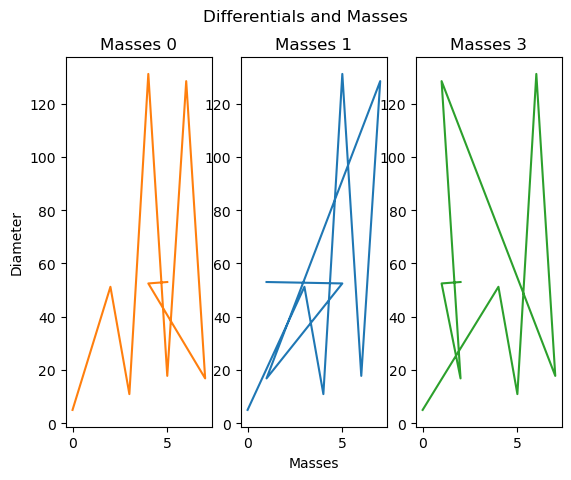

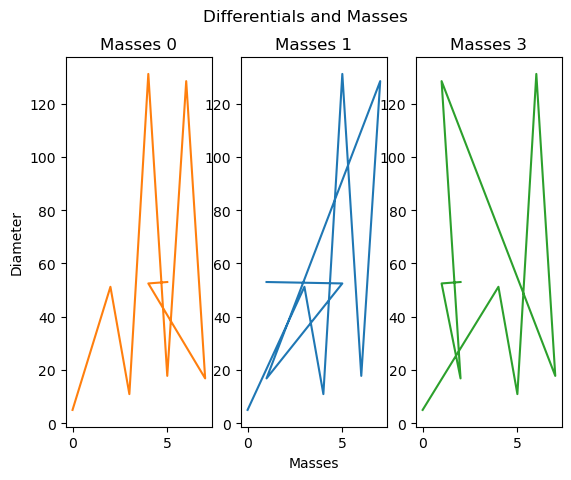

In [16]:
print("Fig 1. ∂D/∂m0 against Masses for the 20th Diameters after 20 simulations")
plot_diffs_and_masses(diffs_m0_xth, masses_0, masses_1, masses_2);
print("\n")
print("Fig 2. ∂D/∂m0 against Masses for the max Diameters after 20 simulations")
plot_diffs_and_masses(diffs_m0_max, masses_0, masses_1, masses_2);

Fig 1. ∂D/∂m1  against Masses for the 20th Diameters after 20 simulations
Fig 2. ∂D/∂m1 against Masses for the max Diameters after 20 simulations

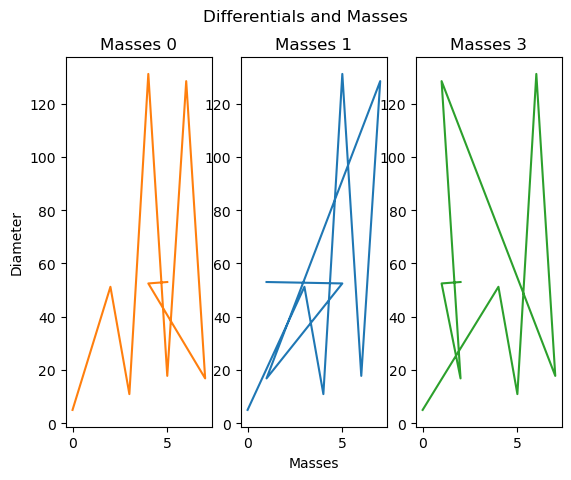

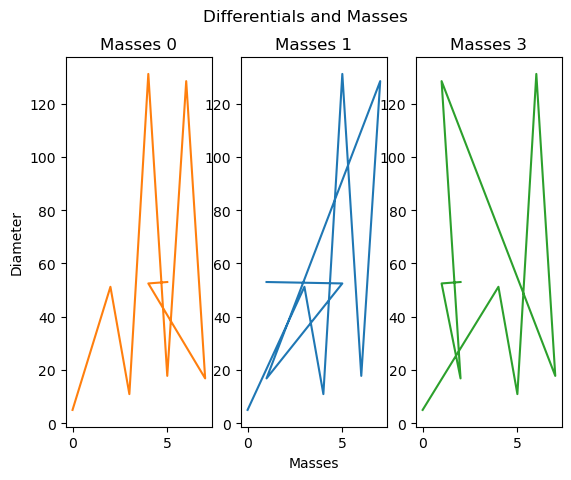

In [17]:
print("Fig 1. ∂D/∂m1  against Masses for the 20th Diameters after 20 simulations")
plot_diffs_and_masses(diffs_m1_xth, masses_0, masses_1, masses_2);
print("\n")
print("Fig 2. ∂D/∂m1 against Masses for the max Diameters after 20 simulations")
plot_diffs_and_masses(diffs_m1_max, masses_0, masses_1, masses_2);

Fig 1. ∂D/∂m2  against Masses for the 20th Diameters after 20 simulations
Fig 2. ∂D/∂m2 against Masses for the max Diameters after 20 simulations

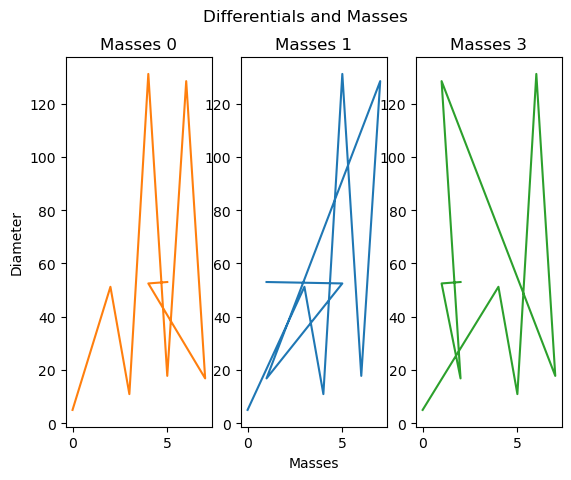

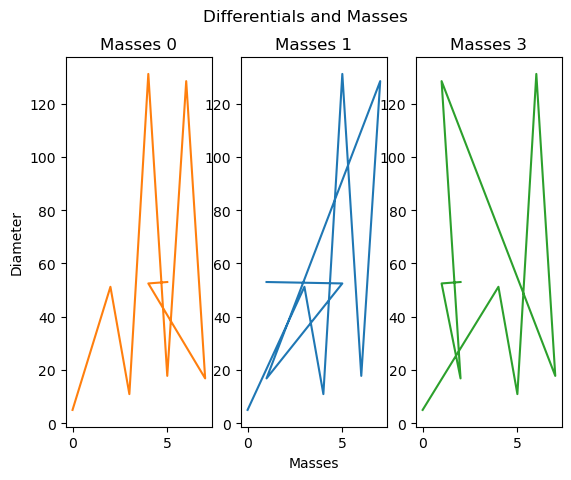

In [18]:
print("Fig 1. ∂D/∂m2  against Masses for the 20th Diameters after 20 simulations")
plot_diffs_and_masses(diffs_m2_xth, masses_0, masses_1, masses_2);
print("\n")
print("Fig 2. ∂D/∂m2 against Masses for the max Diameters after 20 simulations")
plot_diffs_and_masses(diffs_m2_max, masses_0, masses_1, masses_2);

Diameters against Masses for the 20th Diameters after 20 simulations

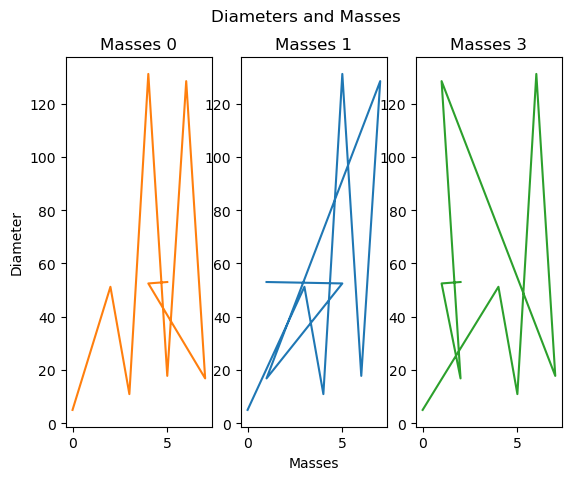

In [19]:
print("Diameters against Masses for the 20th Diameters after 20 simulations")
plot_diams_and_masses(xth_diameters, masses_0, masses_1, masses_2);

Diameters against Masses for the max Diameters after 20 simulations

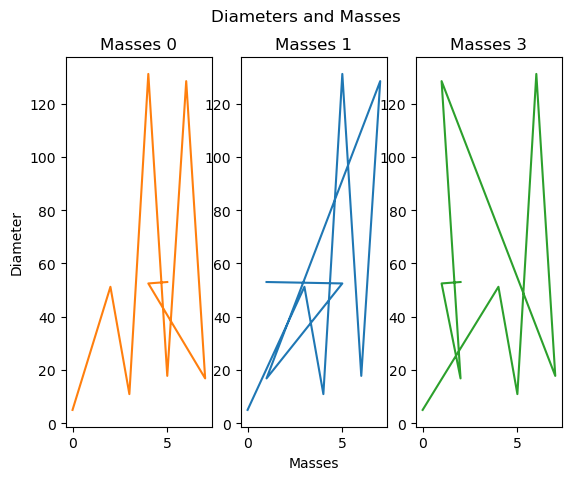

In [20]:
print("Diameters against Masses for the max Diameters after 20 simulations")
plot_diams_and_masses(max_diameters, masses_0, masses_1, masses_2);

Diameters against Masses for the 20th Diameters after 20 simulations

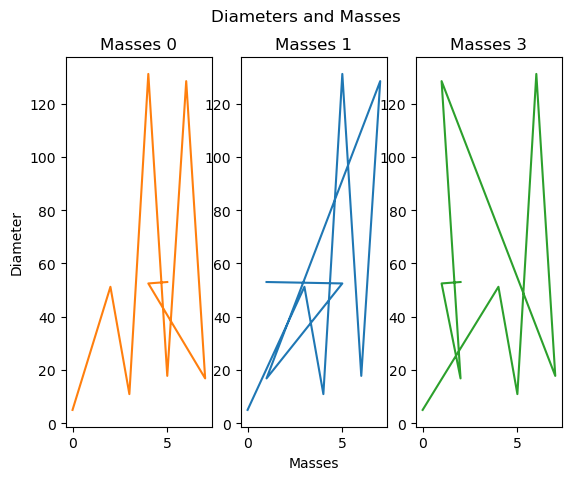

In [21]:
print("Diameters against Masses for the 20th Diameters after 20 simulations")
plot_diams_and_masses(xth_diameters, masses_0, masses_1, masses_2);

Diameters against Masses for the maximum Diameters after 20 simulations

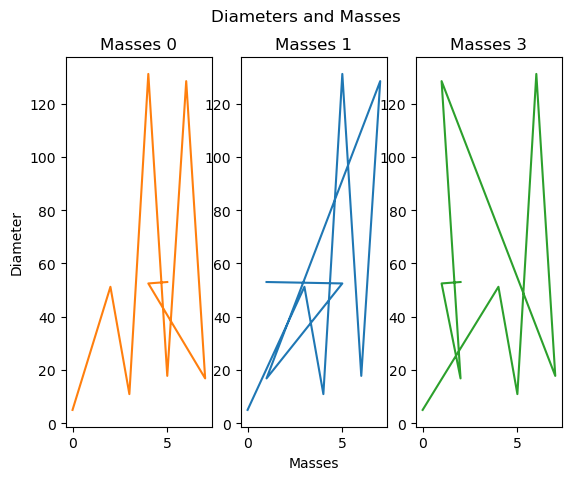

In [22]:
print("Diameters against Masses for the maximum Diameters after 20 simulations")
plot_diams_and_masses(max_diameters, masses_0, masses_1, masses_2);

# End of Experiment

In [129]:
# Initializing variables
# Masses of the bodies
m0 = 5.0
m1 = 4.0
m2 = 3.0

# Initial positions and velocities of each body (x0, y0, vx0, vy0) 
gi0 = [ 1.0, -1.0, 0.0, 0.0]
gi1 = [ 1.0,  3.0, 0.0, 0.0]
gi2 = [-2.0, -1.0, 0.0, 0.0]

# Simulation from time t=0 to t=30
tf  = 30.0
dt  = 500;

r0, v0, r1, v1, r2, v2, cx, cy, t = simulate(m0, m1, m2, gi0, gi1, gi2, tf, dt);
d, d1 = dists_and_diams(r0, r1, r2, t);
print(maximum(d))

r0, v0, r1, v1, r2, v2, cx, cy, t = simulate(m0, m1, m2, gi0, gi1, gi2, tf, dt);
d, d1 = dists_and_diams(r0, r1, r2, t);
print(maximum(d))

r0, v0, r1, v1, r2, v2, cx, cy, t = simulate(m0, m1, m2, gi0, gi1, gi2, tf, dt);
d, d1 = dists_and_diams(r0, r1, r2, t);
print(maximum(d))

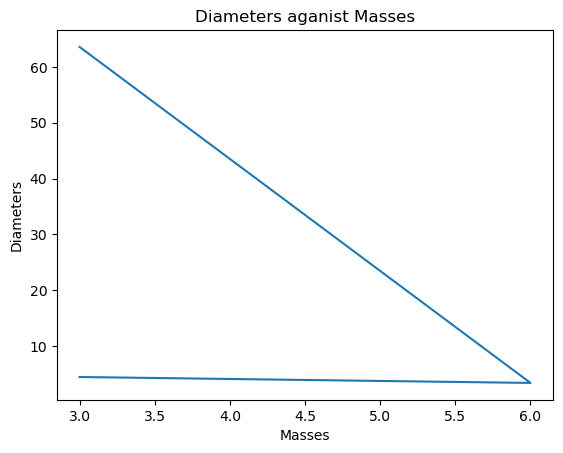

PyObject Text(24.000000000000007, 0.5, 'Diameters')

In [100]:
plot_diams_and_masses(max_diameters, masses_2)
title(@sprintf "Diameters aganist Masses")
xlabel(@sprintf "Masses")
ylabel(@sprintf "Diameters")

In [168]:
data = [5.0, 4.0, 3.0, [1.0, -1.0, 0.0, 0.0], [1.0, 3.0, 0.0, 0.0], [-2.0, -1.0, 0.0, 0.0], 30.0, 500.0];
dis, dis1, dia, dia1, res = run_simulations(data, 3);
print(dia[3], "   ")
print(maximum(dia))
print("\n")

data = [11.0, 2.0, 3.0, [1.0, -1.0, 0.0, 0.0], [1.0, 3.0, 0.0, 0.0], [-2.0, -1.0, 0.0, 0.0], 30.0, 500.0];
dis, dis1, dia, dia1, res = run_simulations(data, 3);
print(dia[3], "   ")
print(maximum(dia))
print("\n")

data = [11.0, 2.0, 3.0, [1.0, -1.0, 0.0, 0.0], [1.0, 3.0, 0.0, 0.0], [-2.0, -1.0, 0.0, 0.0], 30.0, 500.0];
dis, dis1, dia, dia1, res = run_simulations(data, 3);
print(dia[3], "   ")
print(maximum(dia))
print(dia)

63.592215835561845   63.592215835561845
63.592215835561845   63.592215835561845
63.592215835561845   63.592215835561845Any[58.61319754044054, 61.10745141138465, 63.592215835561845]

In [157]:
# Initializing variables
# Masses of the bodies
m0 = 11.0
m1 = 2.0
m2 = 3.0

# Initial positions and velocities of each body (x0, y0, vx0, vy0) 
gi0 = [ 1.0, -1.0, 0.0, 0.0]
gi1 = [ 1.0,  3.0, 0.0, 0.0]
gi2 = [-2.0, -1.0, 0.0, 0.0]

# Simulation from time t=0 to t=30
tf  = 30.0
dt  = 500;

r0, v0, r1, v1, r2, v2, cx, cy, t = simulate(m0, m1, m2, gi0, gi1, gi2, tf, dt);
d, d1 = dists_and_diams(r0, r1, r2, t);
print(maximum(d))
print("\n")

r0, v0, r1, v1, r2, v2, cx, cy, t = simulate(m0, m1, m2, gi0, gi1, gi2, tf, dt);
d, d1 = dists_and_diams(r0, r1, r2, t);
print(maximum(d))
print("\n")

r0, v0, r1, v1, r2, v2, cx, cy, t = simulate(m0, m1, m2, gi0, gi1, gi2, tf, dt);
d, d1 = dists_and_diams(r0, r1, r2, t);
print(maximum(d))

print(d)

58.61319754044054
58.61319754044054
58.61319754044054Any[57.62517446254496, 1.2546100101705555, 58.61319754044054]

5.96759348134258

In [21]:
print(dis)

Any[Any[2.6590174606351487, 3.6363330161606897, 2.6325357643555463], Any[1.262786406257645, 4.453930311129309, 3.28087875758736], Any[1.8086700086669711, 4.1917313940670615, 4.324615764058537]]

In [22]:
print(dia)

Any[3.6363330161606897, 4.453930311129309, 4.324615764058537]

In [12]:
print(dis1)

Any[Any[264.4116785153154, 256.80490209052664, 420.68629520329404], Any[264.6214186089798, 257.8633677063871, 425.28537166587694], Any[265.34194583640175, 260.5406579672846, 432.1593630432968]]

In [13]:
print(dia1)

Any[420.68629520329404, 425.28537166587694, 432.1593630432968]

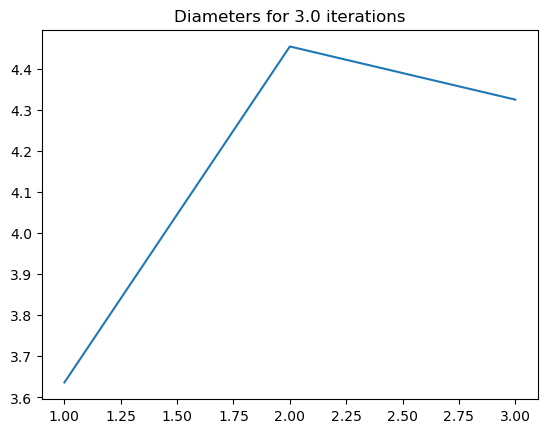

PyObject Text(0.5, 1.0, 'Diameters for 3.0 iterations')

In [17]:
plot_diams(dia)

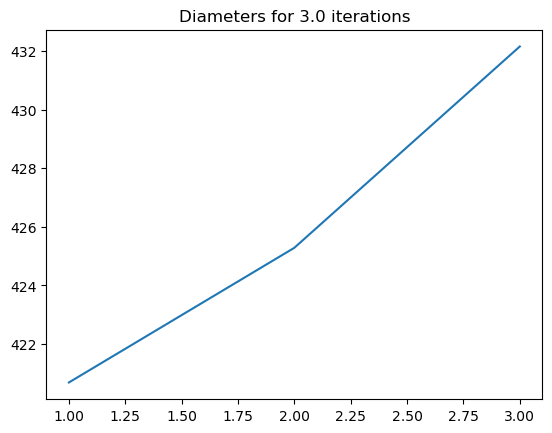

PyObject Text(0.5, 1.0, 'Diameters for 3.0 iterations')

In [18]:
plot_diams(dia1)

In [138]:
print(dis)

Any[Any[2.6590174606351487, 3.6363330161606897, 2.6325357643555463], Any[1.262786406257645, 4.453930311129309, 3.28087875758736], Any[1.8086700086669711, 4.1917313940670615, 4.324615764058537]]

In [139]:
print(dia)

Any[3.6363330161606897, 4.453930311129309, 4.324615764058537]

In [140]:
print(length(res))

3

In [ ]:
a= [1, 2, 3]
b = [3,4,5]
c = [0]

In [ ]:
c = append!(c, [a],[b])

In [372]:
print(c)

[[1, 2, 3], [3, 4, 5]]

In [77]:
r0, v0, r1, v1, r2, v2, cx, cy, t = simulate(m0, m1, m2, gi0, gi1, gi2, tf, dt);

In [78]:
dists, dists1 = dists_and_diams(r0,r1,r2,t);

In [79]:
print(dists)

Any[2.6590174606351487, 3.6363330161606897, 2.6325357643555463]

In [33]:
print("Unscaled Distances and Diameter\n")
print("Dinstance between m0 and m1 is: ", dists[1], "\n")
print("Dinstance between m0 and m2 is: ", dists[2], "\n")
print("Dinstance between m1 and m2 is: ", dists[3], "\n")
print("Diameter is: ", maximum(dists), "\n")
    
print("\nPairwise Distances and Diameter\n")
print("Dinstance between m0 and m1 is: ", dists1[1], "\n")
print("Dinstance between m0 and m2 is: ", dists1[2], "\n")
print("Dinstance between m1 and m2 is: ", dists1[3], "\n")
print("Diameter is: ", maximum(dists1))

Unscaled Distances and Diameter
Dinstance between m0 and m1 is: 2.6590174606351487
Dinstance between m0 and m2 is: 3.6363330161606897
Dinstance between m1 and m2 is: 2.6325357643555463
Diameter is: 3.6363330161606897

Pairwise Distances and Diameter
Dinstance between m0 and m1 is: 264.4116785153154
Dinstance between m0 and m2 is: 256.80490209052664
Dinstance between m1 and m2 is: 420.68629520329404
Diameter is: 420.68629520329404

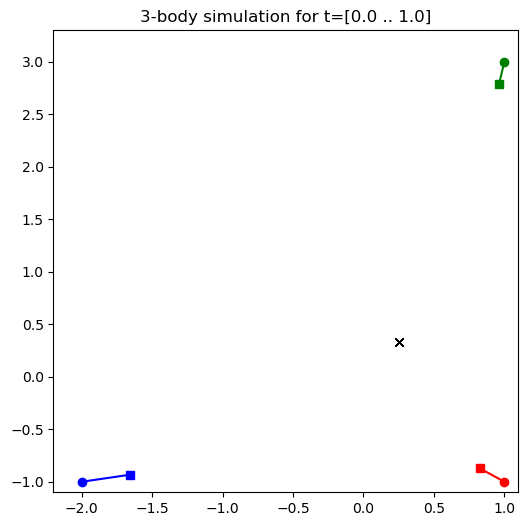

In [34]:
plot_trajectory(0, 1);

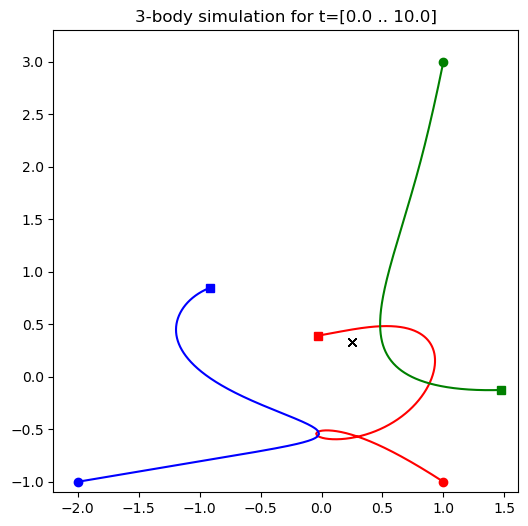

In [308]:
plot_trajectory(0, 10);

In [ ]:
pl

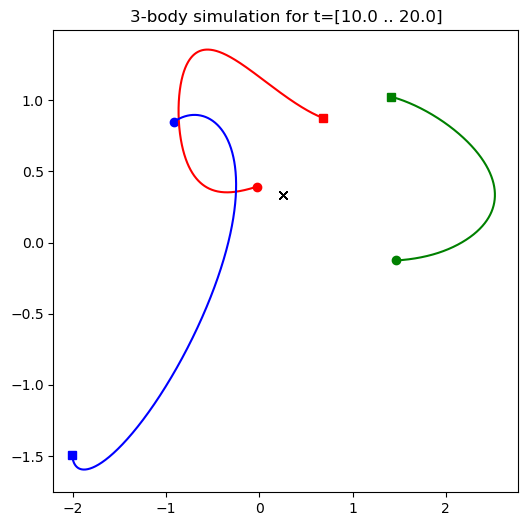

In [309]:
plot_trajectory(10, 20);

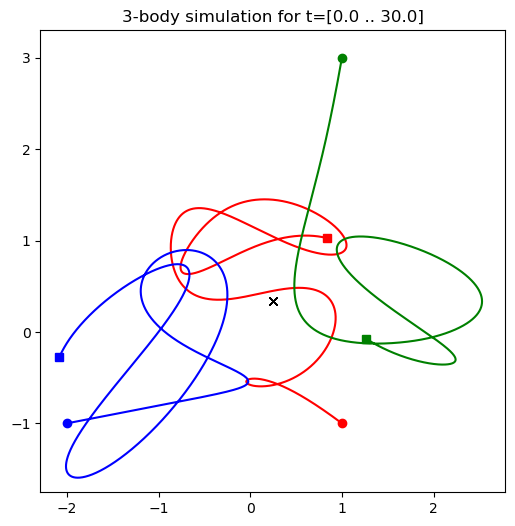

In [310]:
plot_trajectory(0, 30);

In [263]:
dists = []

Any[]

In [21]:
# distances btw each point in the trajectory of m0 and m1
td01 = [evaluate(Euclidean(), [r0[i,1] r0[i,2]], [r1[i,1] r1[i,2]]) for i=1:length(t)]

# distance btw m0 and m1 for last positions
append!(dists, last(td01))

LoadError: UndefVarError: dists not defined

In [265]:
# distances btw each point in the trajectory of m0 and m2
td02 = [evaluate(Euclidean(), [r0[i,1] r0[i,2]], [r2[i,1] r2[i,2]]) for i=1:length(t)]

# distance btw m2 and m0 for last positions
append!(dists,last(td02))

2-element Vector{Any}:
 1.1824120210489852
 3.1980218302661374

In [266]:
# distances btw each point in the trajectory of m2 and m1
td12 = [evaluate(Euclidean(), [r1[i,1] r1[i,2]], [r2[i,1] r2[i,2]]) for i=1:length(t)]

# distance btw m2 and m1 for last positions
append!(dists, last(td12))

3-element Vector{Any}:
 1.1824120210489852
 3.1980218302661374
 3.353998526353206

In [270]:
print(dists)

Any[1.1824120210489852, 3.1980218302661374, 3.353998526353206]

In [279]:
print("Unscaled Distances\n")
print("Dinstance between m0 and m1 is: ", dists[1], "\n")
print("Dinstance between m0 and m2 is: ", dists[2], "\n")
print("Dinstance between m1 and m2 is: ", dists[3], "\n")

Unscaled Distances
Dinstance between m0 and m1 is: 1.1824120210489852
Dinstance between m0 and m2 is: 3.1980218302661374
Dinstance between m1 and m2 is: 3.353998526353206


In [268]:
diameter = maximum(dists)
print(diameter)

3.353998526353206

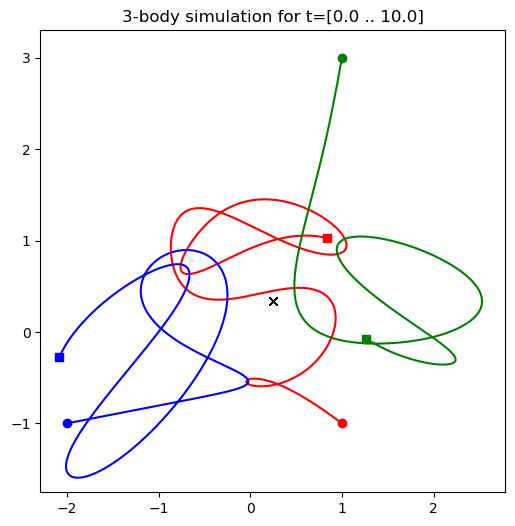

In [269]:
plot_trajectory(0, 10);

In [204]:
x1 = r0[1,1]
y1 = r0[1,2]
x2 = r1[1,1]
y2 = r1[1,2]

3.0

In [207]:
((x2-x1)^2 + (y2-y1)^2)^0.5

4.0

In [218]:
evaluate(Euclidean(), [x1 y1], [x2 y2])

4.0

In [219]:
pairwise(Euclidean(), [x1 y1], [x2 y2])

2×2 Matrix{Float64}:
 0.0  2.0
 2.0  4.0

In [220]:
a0 = [1.0 -1.0; 0.9999992689035611 -0.9999994516780196]
a1 = [1.0 3.0; 0.9999998420831834 2.999999104041769]
pairwise(Euclidean(), a0, a1)

2×2 Matrix{Float64}:
 5.72872e-7  2.82843
 2.82843     5.65685

In [222]:
5.65685322823217 - 4.0

1.65685322823217

In [224]:
evaluate(Euclidean(), [0.9999992689035611 -0.9999994516780196], [0.9999998420831834 2.999999104041769])

3.9999985557198294

In [221]:
evaluate(Euclidean(), a0, a1)

5.65685322823217

In [173]:
# pairwise distances 
pd1 = maximum(pairwise(Euclidean(), r0, r1))
pd2 = maximum(pairwise(Euclidean(), r0, r2))
pd3 = maximum(pairwise(Euclidean(), r1, r2))
pds = [pd1, pd2, pd3]

# diameter (maximum distance between the 3 bodies)
maximum(pds)

35.34271308301422

In [183]:
a = [0.9999992689035611 -0.9999994516780196]
b = [0.9999998420831834 2.999999104041769]

1×2 Matrix{Float64}:
 1.0  3.0

In [184]:
evaluate(Euclidean(), a, b)

3.9999985557198294

In [ ]:
maximum(pairwise(Euclidean(), r0, r2))

In [161]:
evaluate(Euclidean(), r0, r1)

28.27642898716726

In [137]:
evaluate(Euclidean(), r0, r2)

21.201473061960684

In [138]:
evaluate(Euclidean(), r1, r2)

35.34505617031309

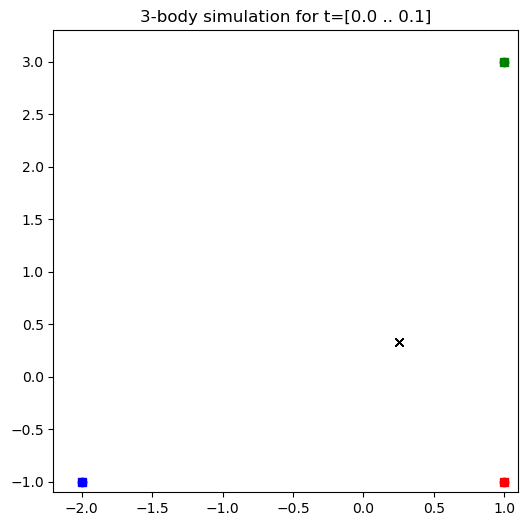

In [140]:
plot_trajectory(0, 0.1);

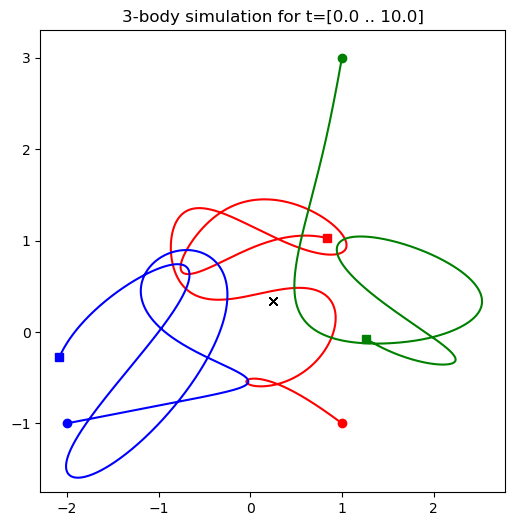

In [78]:
plot_trajectory(0, 10);

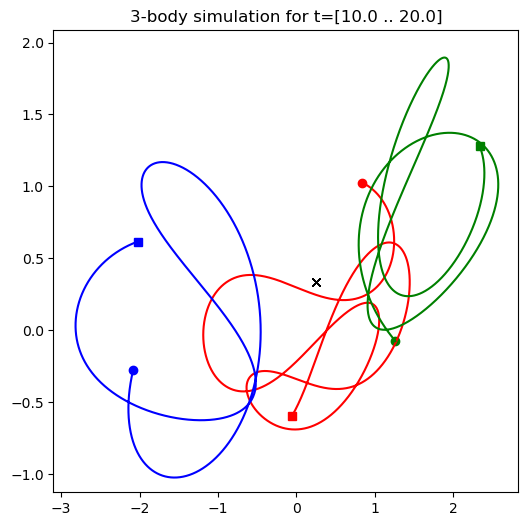

In [79]:
plot_trajectory(10, 20);